In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import sklearn
import seaborn as sn
import datetime
import random
from datetime import date
from pprint import pprint
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.impute import SimpleImputer
import statistics 
from statistics import mode
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeClassifier, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier

In [2]:
def convert_strings_to_dates(dataframe, testset=False):
    frame = dataframe.copy()
    if testset:
        frame.dt = [date.fromisoformat(d) for d in frame.dt]
        frame.first_load_date = [date.fromisoformat(d) for d in frame.first_load_date]
        frame.ts_signup = [datetime.datetime.strptime(d, '%Y-%m-%d %H:%M:%S+00:00') for d in frame.ts_signup]
        frame.ts_signup = [date(year=d.year, month=d.month, day=d.day) for d in frame.ts_signup]
    else:
        frame.dt = [date.fromisoformat(d) for d in frame.dt]
        frame.first_load_date = [date.fromisoformat(d) for d in frame.first_load_date]
        frame.most_recent_load_date = [date.fromisoformat(d) for d in frame.most_recent_load_date]
        frame.ts_signup = [datetime.datetime.strptime(d, '%Y-%m-%d %H:%M:%S+00:00') for d in frame.ts_signup]
        frame.ts_signup = [date(year=d.year, month=d.month, day=d.day) for d in frame.ts_signup]
    return frame

In [3]:
def convert_date_to_int(dataframe, columns):
    frame = dataframe.copy()
    conversion = lambda dt_time: 10000*dt_time.year + 100*dt_time.month + dt_time.day
    
    for col in columns:
        frame[f'{col}'] = [conversion(d) for d in frame[f'{col}']]

    return frame

In [4]:
def aggregate_rows_by_driver_id(dataframe):
    '''
    Returns a new dataframe indexed by Driver ID using an optimal set of aggregations per column.
    This method will return a dataframe that only contains the columns listed below.
    Note: duplicate columns are inherently pruned (simply by not adding them below), so it is 
        safe to pass in the full dataframe and expect a pruned version in return. 
        Also note that the `id_driver` will now be the index of the dataframe and NOT its own column.
    '''
    minimum = 'min'
    maximum = 'max'
    median = 'median'
    random_mode = lambda x: random.choice(pd.Series.mode(x if isinstance(x, list) else list(x)))
    average = lambda x: pd.Series.mean(x)

    aggregation = {
        'dt': maximum,
        'weekday': random_mode,
        'dim_carrier_type': random_mode,
        'carrier_trucks': mode,
        'num_trucks': maximum,
        'interested_in_drayage': random_mode,
        'port_qualified': random_mode,
        'signup_source': random_mode,
        'ts_signup': maximum,
        'days_signup_to_approval': maximum,
        'driver_with_twic': mode,
        'dim_preferred_lanes': mode,
        'first_load_date': minimum,
        'loads': random_mode,
        'marketplace_loads_otr': maximum,
        'marketplace_loads_atlas': maximum,
        'marketplace_loads': maximum,
        'brokerage_loads_otr': maximum,
        'brokerage_loads_atlas': maximum,
        'brokerage_loads': maximum,
        'label': random_mode
    }

    return dataframe.groupby(['id_driver']).agg(aggregation)

In [5]:
def augment_boolean_columns(dataframe):
    frame = dataframe.copy()
    label_encoder = LabelEncoder()
    
    # Replacement (no new columns needed, just transform strings to 0 or 1)
    frame['interested_in_drayage'] = label_encoder.fit_transform(frame.interested_in_drayage)
    frame['port_qualified'] = label_encoder.fit_transform(frame.port_qualified)
    frame['driver_with_twic'] = label_encoder.fit_transform(frame.driver_with_twic)
    
    # Create new columns with more appropriate names, delete the old columns
    frame['self_owned'] = label_encoder.fit_transform(frame.dim_carrier_type)
    frame['mobile_signup'] = np.logical_xor(label_encoder.fit_transform(frame.signup_source), 1).astype(int)
    frame['has_route_preference'] = label_encoder.fit_transform(~frame.dim_preferred_lanes.isnull())
    frame.drop(columns=['dim_carrier_type', 'signup_source', 'dim_preferred_lanes'], inplace=True)
    
    return frame

In [6]:
def encode_categorical_columns(dataframe):
    frame = dataframe.copy()

    # Encode various truck types
    trucks = pd.get_dummies(frame.carrier_trucks)
    trucks.columns = ['truck-' + c.replace('[', '').replace(']', '').replace('"', '').replace(',', '').replace(' ', '-') for c in trucks.columns]
    
    # Encode the 7 different days of the week
    weekdays = pd.get_dummies(frame.weekday)
    weekdays.columns = [f'prefers-{x}'.lower() for x in weekdays.columns]
    
    # Drop the originals since they are no longer needed.
    frame.drop(columns=['carrier_trucks', 'weekday'], inplace=True)
    
    # Concatenate various new frames with the original and return
    result = pd.concat([frame, trucks, weekdays], axis=1)
    return result

In [7]:
def standardize_numericals(dataframe, columns=None):    
    scaler = StandardScaler()
    frame = None
    
    if columns:
        frame = dataframe[columns].copy()
    else:
        frame = dataframe.copy()
    
    x = scaler.fit_transform(frame)
    scaled_df = pd.DataFrame(x)
    scaled_df.columns = frame.columns

    
    if columns:
        frame = dataframe.copy()
        frame[columns] = scaled_df.values
    else:
        frame = scaled_df.copy()
    
    return frame

In [8]:
def impute_numericals(dataframe, columns, strategy='most_frequent', testset=False):
    frame = dataframe.copy()
    imp = SimpleImputer(missing_values=np.nan, strategy=strategy)
    
    for col in columns:
        imp.fit(frame[f'{col}'].values.reshape(-1, 1))
        frame[f'{col}'] = imp.transform(frame[f'{col}'].values.reshape(-1, 1))
    
    return frame

In [9]:
def generate_labels(dataframe, loads_percentile, most_recent_percentile):
    label_encoder = LabelEncoder()
    frame = dataframe.copy()
    
    labels = (frame.total_loads >= loads_percentile) & (frame.most_recent_load_date >= most_recent_percentile)
    frame['label'] = label_encoder.fit_transform(labels)
    frame.drop(columns=['total_loads', 'most_recent_load_date'], inplace=True)
    
    return frame

In [10]:
def get_Xy(dataframe, aggregate=False, standardize=False, testdata=False):
    frame = dataframe.copy()
    scaler = StandardScaler()
    loads_75th_percentile = 17
    most_recent_75th_percentile = date(year=2021, month=2, day=10)


    if testdata:
        frame = convert_strings_to_dates(frame, testset=True)
        frame = augment_boolean_columns(frame)
        frame = encode_categorical_columns(frame)
        frame = convert_date_to_int(frame, columns=['dt', 'ts_signup', 'first_load_date'])

        # The only columns not in the new frame should be booleans that are safely set to 0
        for col in dataframe.columns:
            if col not in frame.columns:
                frame[f'{col}'] = 0

        frame.drop(columns=['weekday'], inplace=True)
        frame = impute_numericals(frame, ['days_signup_to_approval'])

        if standardize:
            frame = standardize_numericals(frame)

        frame.sort_index(axis=1, inplace=True)
        return frame, None
    
    
    frame = convert_strings_to_dates(frame)
    
    if aggregate:
        frame = generate_labels(frame, loads_75th_percentile, most_recent_75th_percentile)
        frame = aggregate_rows_by_driver_id(frame)
        frame = augment_boolean_columns(frame)
        frame = encode_categorical_columns(frame)
        frame = convert_date_to_int(frame, columns=['dt', 'ts_signup', 'first_load_date'])

        labels = frame.label.copy()
        frame.drop(columns=['label'], inplace=True)
        
        if standardize:
            frame = standardize_numericals(frame)

        frame.sort_index(axis=1, inplace=True)
        
        return frame, labels
    else:
        frame = generate_labels(frame, loads_75th_percentile, most_recent_75th_percentile)
        frame = augment_boolean_columns(frame)
        frame = encode_categorical_columns(frame)
        frame = convert_date_to_int(frame, columns=['dt', 'ts_signup', 'first_load_date'])

        labels = frame.label.copy()
        frame.drop(columns=['label'], inplace=True)
        
        if standardize:
            frame = standardize_numericals(frame)

        frame.sort_index(axis=1, inplace=True)
        
        return frame, labels

## Load CSV to DataFrame

In [11]:
train_df = pd.read_csv('training_dataset_V3.csv')
test_df = pd.read_csv('score_V3.csv')

**Drops duplicates and unwanted columns**

In [12]:
train_Ids = train_df['Unnamed: 0']
train_df.drop(columns=['Unnamed: 0', 'load_day', 'ts_first_approved', 'dim_carrier_company_name', 'home_base_city', 'home_base_state', 'id_carrier_number', 'year'], inplace=True)
train_df.dropna(subset=['days_signup_to_approval', 'num_trucks'], inplace=True)

test_Ids = test_df['Unnamed: 0']
test_df.drop(columns=['Unnamed: 0', 'load_day', 'ts_first_approved', 'dim_carrier_company_name', 'home_base_city', 'home_base_state', 'id_carrier_number', 'year'], inplace=True)

---

# 1 - Generate Labels and 4 - Pipeline

In [13]:
# Use this when you want to generate output for Kaggle
X_train, y_train = get_Xy(train_df, standardize=True, aggregate=False, testdata=False)
X_test, _ = get_Xy(test_df, standardize=True, aggregate=False, testdata=True)

In [15]:
# Use this for training/testing your model
#X, y = get_Xy(train_df, standardize=True, aggregate=False, testdata=False)
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [16]:
X_train.shape, y_train.shape

((71072, 40), (71072,))

In [17]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71072 entries, 0 to 71071
Data columns (total 40 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   brokerage_loads                  71072 non-null  float64
 1   brokerage_loads_atlas            71072 non-null  float64
 2   brokerage_loads_otr              71072 non-null  float64
 3   days_signup_to_approval          71072 non-null  float64
 4   driver_with_twic                 71072 non-null  float64
 5   dt                               71072 non-null  float64
 6   first_load_date                  71072 non-null  float64
 7   has_route_preference             71072 non-null  float64
 8   id_driver                        71072 non-null  float64
 9   interested_in_drayage            71072 non-null  float64
 10  loads                            71072 non-null  float64
 11  marketplace_loads                71072 non-null  float64
 12  marketplace_loads_

In [19]:
X_test.shape #y_test.shape

(1000, 40)

# 3 - Statistical Analysis

# 5 - Linear Regression

# 6 - PCA

# 7 - Ensemble Method

In [20]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

# Ada Boost

array([1., 1., 1., 1., 1.])

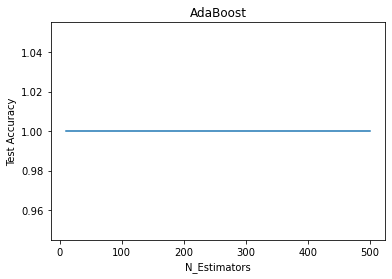

In [21]:
ntrees = [10, 50, 100, 250, 500]
iterations = []
test_accuracy = []

for n in ntrees:
    ada = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1), n_estimators=n, learning_rate=1.0)
    ada.fit(X_train, y_train)
    predictions = ada.predict(X_test)
    test_accuracy = np.append(test_accuracy, ada.score(X_test, predictions))
    
plt.plot(ntrees, test_accuracy)
plt.xlabel("N_Estimators")
plt.ylabel("Test Accuracy")
plt.title("AdaBoost")
test_accuracy

In [22]:
ntrees = 100
iterations = []
test_accuracy = []

for i in range(50, 100):
    ada = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1), n_estimators=i, learning_rate=1.0)
    ada.fit(X_train, y_train)
    predictions = ada.predict(X_test)
    iterations = np.append(iterations, i)
    test_accuracy = np.append(test_accuracy, ada.score(X_test, y_test))
    
plt.plot(iterations, test_accuracy)
plt.xlabel("Number of Iterations")
plt.ylabel("Test Accuracy")
plt.title("AdaBoost")
test_accuracy

NameError: name 'y_test' is not defined

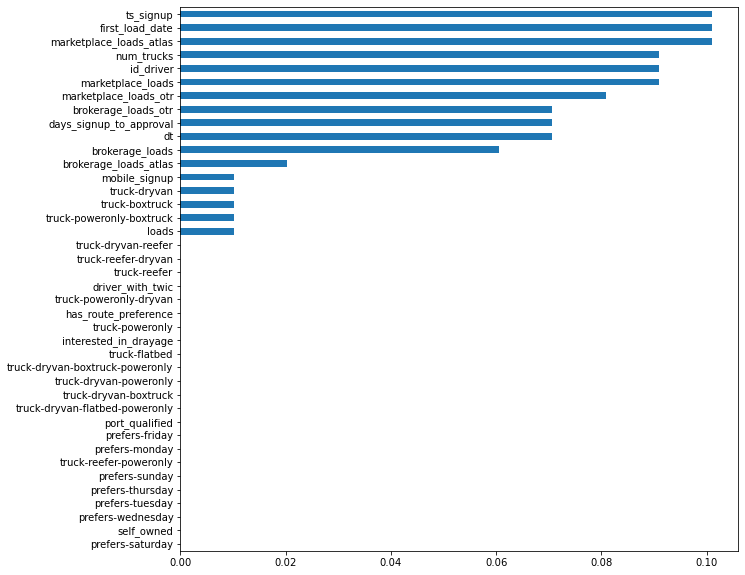

In [105]:
# get importance, n_estimators = 100
pd.Series(ada.feature_importances_,index=list(X_train)).sort_values().plot(kind="barh", figsize=(10,10))

In [106]:
# get importance
importance = ada.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
    print('Predictor: %0d, Score: %.5f' % (i,v))

Predictor: 0, Score: 0.06150
Predictor: 1, Score: 0.01943
Predictor: 2, Score: 0.03509
Predictor: 3, Score: 0.01133
Predictor: 4, Score: 0.03378
Predictor: 5, Score: 0.37322
Predictor: 6, Score: 0.13833
Predictor: 7, Score: 0.00000
Predictor: 8, Score: 0.04650
Predictor: 9, Score: 0.00259
Predictor: 10, Score: 0.00047
Predictor: 11, Score: 0.08248
Predictor: 12, Score: 0.03151
Predictor: 13, Score: 0.02658
Predictor: 14, Score: 0.00000
Predictor: 15, Score: 0.01014
Predictor: 16, Score: 0.07187
Predictor: 17, Score: 0.00000
Predictor: 18, Score: 0.00000
Predictor: 19, Score: 0.00000
Predictor: 20, Score: 0.00000
Predictor: 21, Score: 0.00000
Predictor: 22, Score: 0.00000
Predictor: 23, Score: 0.00000
Predictor: 24, Score: 0.00076
Predictor: 25, Score: 0.00018
Predictor: 26, Score: 0.00068
Predictor: 27, Score: 0.00000
Predictor: 28, Score: 0.00000
Predictor: 29, Score: 0.00000
Predictor: 30, Score: 0.00470
Predictor: 31, Score: 0.00000
Predictor: 32, Score: 0.00000
Predictor: 33, Score

# K-Fold Cross Validation

In [108]:
# evaluate adaboost (n_estimators: 100) for classification
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedShuffleSplit
# evaluate the model
cv = StratifiedShuffleSplit(n_splits=10, random_state=1)
n_scores = cross_val_score(ada, X_test, y_test, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

Accuracy: 0.930 (0.003)


# Random Forest

In [115]:
rf = RandomForestClassifier(n_estimators = 100, max_depth=3, max_features=13)
rf.fit(X_train, y_train)
score = rf.score(X_test, y_test)
print("OG Data Score: " + str(score))

OG Data Score: 0.8590221596904678


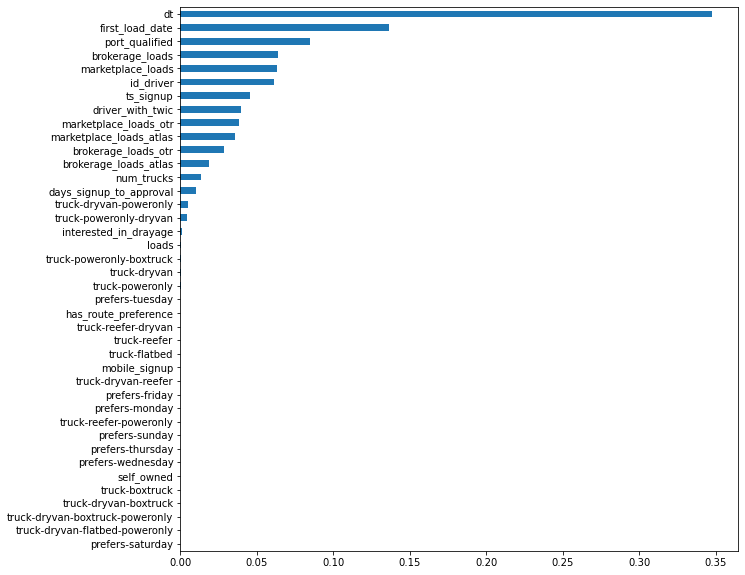

In [116]:
# get importance, n_estimators = 100
pd.Series(rf.feature_importances_,index=list(X_train)).sort_values().plot(kind="barh", figsize=(10,10))

In [117]:
# get importance
importance = rf.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
    print('Predictor: %0d, Score: %.5f' % (i,v))

Predictor: 0, Score: 0.06393
Predictor: 1, Score: 0.01899
Predictor: 2, Score: 0.02839
Predictor: 3, Score: 0.01022
Predictor: 4, Score: 0.03979
Predictor: 5, Score: 0.34753
Predictor: 6, Score: 0.13639
Predictor: 7, Score: 0.00000
Predictor: 8, Score: 0.06140
Predictor: 9, Score: 0.00097
Predictor: 10, Score: 0.00063
Predictor: 11, Score: 0.06338
Predictor: 12, Score: 0.03542
Predictor: 13, Score: 0.03816
Predictor: 14, Score: 0.00000
Predictor: 15, Score: 0.01353
Predictor: 16, Score: 0.08504
Predictor: 17, Score: 0.00000
Predictor: 18, Score: 0.00000
Predictor: 19, Score: 0.00000
Predictor: 20, Score: 0.00000
Predictor: 21, Score: 0.00000
Predictor: 22, Score: 0.00000
Predictor: 23, Score: 0.00000
Predictor: 24, Score: 0.00000
Predictor: 25, Score: 0.00000
Predictor: 26, Score: 0.00052
Predictor: 27, Score: 0.00000
Predictor: 28, Score: 0.00000
Predictor: 29, Score: 0.00000
Predictor: 30, Score: 0.00483
Predictor: 31, Score: 0.00000
Predictor: 32, Score: 0.00000
Predictor: 33, Score

# K-Fold Cross Validation

In [112]:
# evaluate adaboost algorithm for classification
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedShuffleSplit
# evaluate the model
cv = StratifiedShuffleSplit(n_splits=10, random_state=1)
n_scores = cross_val_score(rf, X_test, y_test, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))

Accuracy: 0.855 (0.013)


# 8 - Neural Network

# 9 - Cross Validation

# 10 - Custom Model

In [17]:
clf = MLPClassifier()
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.9866338374956032